In [1]:
import xml.etree.cElementTree as ET
import re
import pprint
from collections import defaultdict
import os

#### Notes:
Original osm data file is too big to be submitted with this report, you can download it from [Shanghai metro extract](https://mapzen.com/data/metro-extracts/metro/shanghai_china/).

#### Index:
1. Generate sample osm file
2. Preliminary inspection
3. Clean and import data to MongoDB
4. Further cleaning in MongoDB
5. File summary & data exploration

## Part 1: Generate sample osm file

Code below will generate a 1/100 sample from original xml file (Generated sample file is already in the folder).

In [2]:
OSM_FILE = "shanghai_china.osm"
SAMPLE_FILE = "shanghai_sample.osm"

k = 100 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    '''
    Args:
        osm_file: original osm to sample from
        tags: types of tag to extract
    Returns:
        an extracted element
    '''
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n'.encode('utf-8'))
    output.write('<osm>\n  '.encode('utf-8'))

    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='utf-8'))
            
    output.write('</osm>'.encode('utf-8'))

## Part 2: Preliminary inspection

Before conducting data cleaning and import to mongoDB, let's take a quick look on the sampled osm xml data:

In [3]:
def count_tags(filename):
    '''
    Args: 
        filename: an osm file
    Returns:
        a dictionary:
            key: the tag names found in the osm file
            value: count of each tag in the osm file
        
    '''
    result=defaultdict(int)
    for event, elem in ET.iterparse(filename):
        result[elem.tag]+=1
        
    return result

count_tags('shanghai_sample.osm')

defaultdict(int,
            {'member': 338,
             'nd': 37405,
             'node': 31365,
             'osm': 1,
             'relation': 25,
             'tag': 11229,
             'way': 3860})

Since most real data are stored in the 'tag' tag, let's take a closer look of 'tag':

In [4]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\.\t\r\n]')

def key_type(element, keys):
    '''
    Args:
        element: an element extract from osm file by ET.interparse()
        keys: a dictionary that contains pre-defined key types and their counts
    Returns:
        an updated dictionary with the element categorized
    '''
    if element.tag == "tag":
        key=element.attrib['k']
        if lower.search(key)!=None:
            keys['lower']+=1
        elif lower_colon.search(key)!=None:
            keys['lower_colon']+=1
        elif problemchars.search(key)!=None:
            keys['problemchars']+=1
        else:
            keys['other']+=1
            print(key,"/",element.attrib['v'])
    return keys

def check_key(filename):
    '''
    Args:
        filename: an osm file
    Returns:
        adopt key_types() function on every element of input file and return the final summary dictionary
    '''
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)
    return keys

check_key('shanghai_sample.osm')

gns:DSG / ADM3
gns:UFI / -1910407
gns:UNI / 6719592
gns:ADM1 / 23
gns:DSG / ADM4
gns:UFI / 10077134
gns:UNI / 10275248
gns:ADM1 / 04
gns:DSG / ADM3
gns:UFI / 9264839
gns:UNI / 9346612
gns:ADM1 / 02
generator:output:electricity / 610 MW
name:zh-hant / 蔡倫路
name:zh-hant / 橫沔江路
name:zh-hant / 孫橋路
name:zh-hant / 羅山高架路
name:zh-hant / 層林路
name:zh-hant / 兩港大道
name:zh-hant / 南蘆公路
name:zh-hant / 兩港大道
name:zh-hant / 嘉澤路
width:lanes:end / 3.09|3.11|3.18|3.08|2.22
width:lanes:start / 3.09|3.11|3.18|3.08|2.22
name:zh-hant / 羅山高架路
addr:street:en / East Zhongshan No. 1 Road


{'lower': 10171, 'lower_colon': 1032, 'other': 26, 'problemchars': 0}

- Seems most tag's k attribute has the 'lower' or 'lower_colon' format, no k attribute contains problematic charaters.
- There are 26 attributes fall into 'other' category, which are printed out with 'k value/ v value' format. Those results remind me to replace ":" and "-" during data cleaning.

---
Let's check how many kinds of k tags appeared in this sample:

In [5]:
def count_tag_k(filename):
    '''
    Args:
        filename: an osm file
    Returns:
        a dictionary with the count of each tag name
    '''
    result=defaultdict(int)
    for event, elem in ET.iterparse(filename):
        if (elem.tag=='tag'):
            result[elem.attrib['k']]+=1
    return result

count_tag_k('shanghai_sample.osm')

defaultdict(int,
            {'access': 25,
             'addr:city': 18,
             'addr:door': 1,
             'addr:housename': 7,
             'addr:housenumber': 44,
             'addr:interpolation': 2,
             'addr:neighbourhood': 1,
             'addr:postcode': 7,
             'addr:street': 38,
             'addr:street:en': 1,
             'admin_level': 12,
             'aeroway': 28,
             'alt_name': 1,
             'alt_name:vi': 1,
             'amenity': 117,
             'architect': 1,
             'area': 10,
             'atm': 3,
             'attraction': 1,
             'backrest': 2,
             'barrier': 37,
             'bench': 22,
             'bicycle': 25,
             'board_type': 1,
             'boat': 5,
             'boundary': 10,
             'bridge': 366,
             'building': 1178,
             'building:colour': 13,
             'building:levels': 81,
             'building:material': 2,
             'building:part': 19,
 

Two major findings:
- The data would be better organized if all the attributes with prefix 'addr:' are grouped into 'address' collection, all the attributes with prefix 'building' are grouped into 'building_info'
- Name are recorded in different languages, they should be grouped into one 'name' collection

---
Besides attributes mentioned above, two attributes' frequency exceeds 1000 in this sample data, they are 'highway' and 'source'. Let's take of look of the values of those two attributes:

In [6]:
def check_value(filename,value):
    '''
    Args:
        filename: an osm file
        value: a string as the name of the tag to summarise
    Returns:
        a dictionary with the count of the contents of chosen tag
    '''
    result=defaultdict(int)
    for event, elem in ET.iterparse(filename):
        if (elem.tag=='tag'):
            if elem.attrib['k']==value:
                result[elem.attrib['v']]+=1
    return result

check_value('shanghai_sample.osm','source')

defaultdict(int,
            {'Bing': 293,
             'Bing 2010': 2,
             'Bing Imagery': 1,
             'Bing,2009-12': 1,
             'Bing,2012-1': 1,
             'Bing,2013-11': 2,
             'China Data Center, University of Michigan': 2,
             'GISmaps/std': 2,
             'GNS': 1,
             'GPS': 64,
             'GPS + Bing': 1,
             'GPS track in OSM': 1,
             'GPS+Bing': 1,
             'Lakewalker / Landsat': 1,
             'Landsat': 1,
             'Mapbox': 1,
             'PGS': 881,
             'Strava': 1,
             'Yahoo': 1,
             'Yahoo hires': 5,
             'Yahoo imagery': 1,
             'bing': 60,
             'bing,2010': 1,
             'bing_imagery': 1,
             'estimated': 2,
             'estimation': 5,
             'extrapolation': 1,
             'https://upload.wikimedia.org/wikipedia/commons/b/b5/Administrative_Division_Jiaxing.png': 1,
             'interpolation': 2,
             'loc

There are some major sources, such as Bing and GPS, seems those values can be cleaned and grouped into standardized categories.

In [7]:
check_value('shanghai_sample.osm','highway')

defaultdict(int,
            {'bus_stop': 59,
             'construction': 5,
             'crossing': 48,
             'cycleway': 15,
             'footway': 83,
             'living_street': 8,
             'motorway': 130,
             'motorway_junction': 6,
             'motorway_link': 73,
             'path': 27,
             'pedestrian': 14,
             'primary': 165,
             'primary_link': 34,
             'residential': 429,
             'road': 5,
             'secondary': 222,
             'secondary_link': 15,
             'service': 264,
             'steps': 10,
             'tertiary': 287,
             'tertiary_link': 2,
             'track': 26,
             'traffic_signals': 31,
             'trunk': 35,
             'trunk_link': 17,
             'turning_circle': 1,
             'unclassified': 227})

Values of 'highway' is cleaner, I don't have better idea to organize it, so let's just leave it that way.

## Part 3: Clean and import data to MongoDB

In [8]:
import pymongo
from pymongo import MongoClient
import pprint
import codecs
import json

First Let's create some functions to clean up raw data according to findings from earlier observations:

In [9]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]

def source_clean(source):
    '''
    Args: 
        source: a string representing the content of a 'source' tag
    Returns:
        a standardized string as the new content
    '''
    if source[:4].lower()=='bing':
        return 'Bing'
    elif source[:5].lower()=='yahoo':
        return 'Yahoo'
    elif source[:3]=='GPS':
        return 'GPS'
    else:
        return source


def shape_element(element):
    '''
    Args:
        element: an element extracted from an osm file
    Returns:
        a JSON node containing the cleaned element data
    '''
    node = {}
    if element.tag in ["node","way","relation"]:
        node['type']=element.tag
        node['created']={}
        for item in element.attrib:
            if (item in CREATED):
                node['created'][item]=element.attrib[item]
            elif (item=='lat')|(item=='lon'):
                pos=[float(element.attrib['lat']),float(element.attrib['lon'])]
                node['pos']=pos
            else:
                node[item]=element.attrib[item]
            
        address={}
        building={}
        name={}
        for tag in element.iter('tag'):
            # Abandon data with problematic characters 
            if problemchars.search(tag.attrib['k'])!=None:
                next
                
            # Grouping Address info
            elif tag.attrib['k'][:5]=='addr:':
                address[tag.attrib['k'][5:].replace(":","_")]=tag.attrib['v']
                
            # Grouping Name info
            elif tag.attrib['k']=='name':
                name['zh']=tag.attrib['v']
            elif tag.attrib['k'][:5]=='name:':
                name[tag.attrib['k'][5:].replace(":","_")]=tag.attrib['v']
            
            # Grouping Building info
            elif tag.attrib['k'][:8]=='building':
                if tag.attrib['k']=='building':
                    building['building']=tag.attrib['v']
                else:
                    building[tag.attrib['k'][9:].replace(":","_")]=tag.attrib['v']                
            
            # Cleaning source content
            elif tag.attrib['k'][:6]=='source':
                node['source']=source_clean(tag.attrib['v'])
                
            # Replace colon with underscore to create valid name
            else:
                node[tag.attrib['k'].replace(":","_")]=tag.attrib['v']
                
        if address!={}:
            node['address']=address
        if name!={}:
            node['name']=name
        if building!={}:
            node['building']=building
            
        node_refs=[]
        for nd in element.iter('nd'):
            node_refs.append(nd.attrib['ref'])
        if node_refs!=[]:
            node['node_refs']=node_refs
        return node
    else:
        return None

Then, let's created a function to fetch raw data from original osm file, clean them and save them into JSON file:

In [10]:
def process_map(file_in):
    '''
    Args:
        file_in: an osm file
    Returns:
        None
        this function iterate through the osm file, adopt shape_element() function on each element and save the output to a json file
    '''
    i=0
    file_out = "{0}.json".format(file_in)
    with codecs.open(file_out, "w") as fo:
        fo.write('[')
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                if i==0:
                    fo.write(json.dumps(el, indent=2)+"\n")
                else:
                    fo.write(","+json.dumps(el, indent=2)+"\n")
                i+=1
                if i%10000==0:
                    print(i/10000)
                    
        fo.write(']')

        print("{} data entries saved to json file".format(i))
    return None

It takes some time to run following function, use 'shanghai_sample.osm' instead if you just want to test the code.

In [ ]:
process_map('shanghai_china.osm')

Then, import the JSON file into MongoDB, database 'udacity_p3', collection 'shanghai_china':

In [11]:
# Mongod was already opened in separate command line window
client = MongoClient()
collection=client.udacity_p3.shanghai_china

In [12]:
with open('shanghai_china.osm.json') as data_file:    
    data = json.load(data_file)
collection.insert_many(data)

In [13]:
collection.find().count()

3524981

## Part 4: Further cleaning in MongoDB

I have cleaned names of different languages earlier, now let's check whether we can further clean name types:

In [14]:
pipeline=[
    {'$match':{'name':{'$exists':1}}},
    {'$project':{'name':1}}
]
query_result=list(collection.aggregate(pipeline))
len(query_result)

94799

In particular, I want to organize names in English and all kinds of Chinese, since those two languages are most frequently recorded:

In [15]:
def name_set(query_result):
    '''
    Args:
        query_result: a MongoDB aggregate query result
    Returns:
        a dictionary with the counts of name field of the query result
    '''
    result=defaultdict(int)
    for item in query_result:
        for key in item['name']:
            result[key]+=1
    return result

def find_zh_py_en(query_result):
    '''
    Args:
        query_result: a MongoDB aggregate query result
    Returns:
        a dictionary of sets, with field names categorized into Chinese, Chinese Pinyin and English 
    
    '''
    name_keys=name_set(query_result).keys()
    zh=[]
    en=[]
    py=[]
    for key in name_keys:
        if re.compile(r'zh').search(key):
            zh.append(key)
        if (re.compile(r'py').search(key)) or (re.compile(r'pinyin').search(key)):
            py.append(key)
        if re.compile(r'en').search(key):
            en.append(key)
    return {'zh':set(zh),'py':set(py),'en':set(en)}

In [16]:
find_zh_py_en(query_result)

{'en': {'UN_en', 'en'},
 'py': {'bpy', 'pinyin', 'zh_pinyin', 'zh_py', 'zh_pyt'},
 'zh': {'UN_zh',
  'zh',
  'zh-CN',
  'zh-Hant-CN',
  'zh-classical',
  'zh-hant',
  'zh-hant-CN',
  'zh-min-nan',
  'zh-simplified',
  'zh-traditional',
  'zh-traditonal',
  'zh_pinyin',
  'zh_py',
  'zh_pyt'}}

Some field names actually mean the same thing. For example: zh-traditonal is a typo, zh-traditional,zh-hant,zh-hant-CN,zh-Hant-CN,zh-classical all represent traditional Chinese. So we better rename those fields.

In [17]:
en=['UN_en']
pinyin=['bpy', 'zh_pinyin', 'zh_py', 'zh_pyt']
zh_hant=[ 'zh-Hant-CN','zh-classical','zh-hant','zh-hant-CN','zh-traditional','zh-traditonal']
zh_simp=['UN_zh','zh','zh-CN', 'zh-simplified']
for item in en:
    collection.update_many( {}, { '$rename': { "name."+item: "name.en" }})
for item in pinyin:
    collection.update_many( {}, { '$rename': { "name."+item: "name.pinyin" }})
for item in zh_hant:
    collection.update_many( {}, { '$rename': { "name."+item: "name.zh_hant" }})
for item in zh_simp:
    collection.update_many( {}, { '$rename': { "name."+item: "name.zh_simp" }})

Let's run the same query again and now the name fields are well-organized:

In [18]:
pipeline=[
    {'$match':{'name':{'$exists':1}}},
    {'$project':{'name':1}}
]
query_result=list(collection.aggregate(pipeline))
find_zh_py_en(query_result)

{'en': {'en'}, 'py': {'pinyin'}, 'zh': {'zh-min-nan', 'zh_hant', 'zh_simp'}}

In [19]:
name_count=name_set(query_result)
print('Simplified Chinese:',name_count['zh_simp'])
print('English:',name_count['en'])
print('Chinese Pinyin:',name_count['pinyin'])
print('Traditional Chinese:',name_count['zh_hant'])

Simplified Chinese: 93275
English: 44866
Chinese Pinyin: 4796
Traditional Chinese: 1052


Next we are going to clean 'source':

In [20]:
pipeline=[
    {'$match':{'source':{'$exists':1}}},
    {'$group':{'_id':'$source','count':{'$sum':1}}},
    {'$sort':{'count':-1}},
    {'$limit':20}
]
list(collection.aggregate(pipeline))

[{'_id': 'PGS', 'count': 87342},
 {'_id': 'Bing', 'count': 37504},
 {'_id': 'GPS', 'count': 6650},
 {'_id': 'Yahoo', 'count': 643},
 {'_id': 'survey', 'count': 534},
 {'_id': 'osm-gpx', 'count': 471},
 {'_id': 'interpolation', 'count': 319},
 {'_id': 'GNS', 'count': 279},
 {'_id': 'estimation', 'count': 211},
 {'_id': 'GISmaps/std', 'count': 156},
 {'_id': "potlatch's P-key", 'count': 150},
 {'_id': 'landsat', 'count': 147},
 {'_id': 'Landsat', 'count': 138},
 {'_id': 'Lakewalker / Landsat', 'count': 106},
 {'_id': 'Survey', 'count': 105},
 {'_id': 'photograph', 'count': 93},
 {'_id': 'estimated', 'count': 83},
 {'_id': 'extrapolation', 'count': 68},
 {'_id': 'Landsat Imagery', 'count': 64},
 {'_id': 'Mapbox', 'count': 62}]

Seems we can further group 'Lansat', 'landsat', 'Landsat Imagery' together. We can also group words meaning 'estimation' together.

In [21]:
collection.update_many({'source':{'$in':['landsat','Landsat Imagery']}},{'$set':{'source':'Landsat'}})
collection.update_many({'source':{'$in':['interpolation','estimation','estimated','extrapolation']}},{'$set':{'source':'Estimation'}})

Check again, now the sources are better organized:

In [22]:
pipeline=[
    {'$match':{'source':{'$exists':1}}},
    {'$group':{'_id':'$source','count':{'$sum':1}}},
    {'$sort':{'count':-1}},
    {'$limit':20}
]
list(collection.aggregate(pipeline))

[{'_id': 'PGS', 'count': 87342},
 {'_id': 'Bing', 'count': 37504},
 {'_id': 'GPS', 'count': 6650},
 {'_id': 'Estimation', 'count': 681},
 {'_id': 'Yahoo', 'count': 643},
 {'_id': 'survey', 'count': 534},
 {'_id': 'osm-gpx', 'count': 471},
 {'_id': 'Landsat', 'count': 349},
 {'_id': 'GNS', 'count': 279},
 {'_id': 'GISmaps/std', 'count': 156},
 {'_id': "potlatch's P-key", 'count': 150},
 {'_id': 'Lakewalker / Landsat', 'count': 106},
 {'_id': 'Survey', 'count': 105},
 {'_id': 'photograph', 'count': 93},
 {'_id': 'Mapbox', 'count': 62},
 {'_id': 'China Data Center, University of Michigan', 'count': 45},
 {'_id': 'Strava', 'count': 36},
 {'_id': 'PGS & Bing', 'count': 26},
 {'_id': 'wild_guess', 'count': 22},
 {'_id': 'scanaerial', 'count': 22}]

## Part 5: File summary & data exploration

#### File size summary:

In [23]:
print("shanghai_sample.osm:",round(os.path.getsize("shanghai_sample.osm")/1024/1024),'M')
print("shanghai_sample.osm.json:",round(os.path.getsize("shanghai_sample.osm.json")/1024/1024),'M')
print("shanghai_china.osm:",round(os.path.getsize("shanghai_china.osm")/1024/1024),'M')
print("shanghai_china.osm.json:",round(os.path.getsize("shanghai_china.osm.json")/1024/1024),'M')

shanghai_sample.osm: 6 M
shanghai_sample.osm.json: 10 M
shanghai_china.osm: 633 M
shanghai_china.osm.json: 961 M


#### Document summary:

In [24]:
# Number of Documents:
print(collection.find().count())
# Number of Nodes:
print(collection.find({'type':'node'}).count())
# Number of Ways:
print(collection.find({'type':'way'}).count())

3524981
3136392
385795


#### User summary:

In [25]:
# Number of Unique Users:
len(collection.distinct('created.user'))

2041

In [26]:
# Top 5 Contributing Users:
pipeline=[
        {'$match':{'created.user':{'$exists':1}}},
        {'$group':{'_id':'$created.user','count':{'$sum':1}}},
        {'$sort':{'count':-1}},
        {'$limit':5}
    ]
list(collection.aggregate(pipeline))

[{'_id': 'Chen Jia', 'count': 661742},
 {'_id': 'aighes', 'count': 183143},
 {'_id': 'katpatuka', 'count': 137812},
 {'_id': 'XBear', 'count': 126490},
 {'_id': 'yangfl', 'count': 112884}]

In [27]:
# Number of users who only contribute once
pipeline=[
        {'$match':{'created.user':{'$exists':1}}},
        {'$group':{'_id':'$created.user','count':{'$sum':1}}},
        {'$match':{'count':{'$eq':1}}}
    ]
len(list(collection.aggregate(pipeline)))

408

#### Additional exploration:

Top 2 amenities are bicycle rental and parking, both of which are transportation related. It is interesting that toilet is in top 10.

In [28]:
# Top 10 amenities
pipeline=[
    {'$match':{'amenity':{'$exists':1}}},
    {'$group':{'_id':'$amenity','count':{'$sum':1}}},
    {'$sort':{'count':-1}},
    {'$limit':10}    
]
list(collection.aggregate(pipeline))

[{'_id': 'bicycle_rental', 'count': 2436},
 {'_id': 'parking', 'count': 1323},
 {'_id': 'school', 'count': 1231},
 {'_id': 'restaurant', 'count': 1229},
 {'_id': 'bank', 'count': 588},
 {'_id': 'toilets', 'count': 410},
 {'_id': 'fuel', 'count': 357},
 {'_id': 'cafe', 'count': 354},
 {'_id': 'fast_food', 'count': 339},
 {'_id': 'hospital', 'count': 338}]

No surprise, top 1 cuisine is Chinese food, followed by burger/pizza/chicken. Popular fast food is the same in every big city.

In [30]:
pipeline=[
    {'$match':{'cuisine':{'$exists':1}}},
    {'$group':{'_id':'$cuisine','count':{'$sum':1}}},
    {'$sort':{'count':-1}},
    {'$limit':10}    
]
list(collection.aggregate(pipeline))

[{'_id': 'chinese', 'count': 161},
 {'_id': 'burger', 'count': 51},
 {'_id': 'pizza', 'count': 31},
 {'_id': 'chicken', 'count': 31},
 {'_id': 'coffee_shop', 'count': 30},
 {'_id': 'italian', 'count': 14},
 {'_id': 'japanese', 'count': 14},
 {'_id': 'american', 'count': 14},
 {'_id': 'international', 'count': 12},
 {'_id': 'asian', 'count': 12}]

Water and trees are most common natural objects in this city. Since the east side of shanghai is sea, coastline is also frequently marked in OSM.

In [31]:
pipeline=[
    {'$match':{'natural':{'$exists':1}}},
    {'$group':{'_id':'$natural','count':{'$sum':1}}},
    {'$sort':{'count':-1}},
    {'$limit':10}    
]
list(collection.aggregate(pipeline))

[{'_id': 'water', 'count': 6288},
 {'_id': 'tree', 'count': 3454},
 {'_id': 'coastline', 'count': 1631},
 {'_id': 'wood', 'count': 986},
 {'_id': 'scrub', 'count': 124},
 {'_id': 'sand', 'count': 108},
 {'_id': 'tree_row', 'count': 80},
 {'_id': 'peak', 'count': 80},
 {'_id': 'wetland', 'count': 50},
 {'_id': 'grassland', 'count': 36}]

I also want to explore all those osm nodes' geographic position by plotting their latitude and longtitude and highlight restaurants in particular.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [33]:
pipeline=[
    {'$match':{'pos':{'$exists':1}}},
    {'$project':{'_id':0,'pos':1}}
    ]
    
result=list(collection.aggregate(pipeline))

In [34]:
lat=[]
long=[]
for item in result:
    lat.append(item['pos'][0])
    long.append(item['pos'][1])
x1=np.array(long)
y1=np.array(lat)

In [35]:
pipeline=[
    {'$match':{'pos':{'$exists':1},'amenity':{'$eq':'restaurant'}}},
    {'$project':{'_id':0,'pos':1}}
    ]    
result=list(collection.aggregate(pipeline))

In [36]:
lat=[]
long=[]
for item in result:
    lat.append(item['pos'][0])
    long.append(item['pos'][1])
x2=np.array(long)
y2=np.array(lat)

Some obvious clusters can be observed, that will be explained in the pdf report.

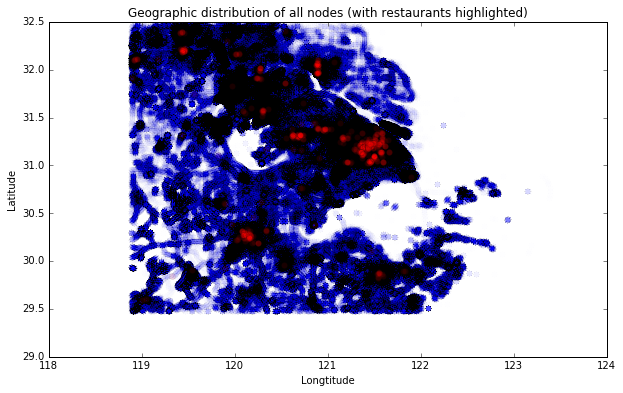

In [37]:
plt.plot(x1,y1,'o',alpha=0.003)
plt.plot(x2,y2,'o',color='r',alpha=0.1)
plt.title('Geographic distribution of all nodes (with restaurants highlighted)')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.show()